# Robust Inference with Power scalings

It can be frustrating to fit models where

* **the prior is misspecified**: For example, the true value lies outside the range or far in the tails of the prior distribution.
  * -> Therefore the sampler struggles to find the value
* **the model is misspecified**: For example, residuals remain with the best-fit model, or additional scatter is present which is not modelled.
  * -> This leads to tiny nominal uncertainties, but in reality the model is a poor fit (bias-variance trade-off).

To address these, we take ideas from this paper: https://arxiv.org/pdf/2107.14054.pdf (and this one: https://arxiv.org/pdf/1908.04655)

Specifically, we allow:

* Dampening of the prior by a power: $P(\theta)' \propto P(\theta)^\beta$
* Dampening of the likelihood by a power: $P(D|\theta)' \propto P(D|\theta)^\gamma$

For these two additional parameters we set a prior that prefers values close to 1. The sampler is allowed to increase these values as needed. If $\beta$ becomes large, we know the prior was poorly chosen. If $\gamma$ becomes large, we know the model is poorly chosen.


As a specific example, we fit a line.

We (wrongly) believe the line offset is close to 0, and that there is only known measurement error.

But our data are actually quite different:

In [91]:
import numpy as np
from numpy import exp, log, pi
import matplotlib.pyplot as plt
import scipy.stats

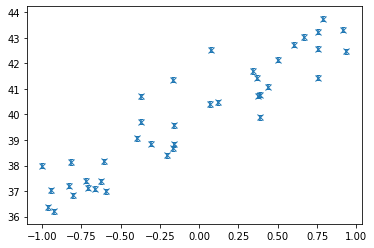

In [92]:
np.random.seed(1)

Ndata = 40
x = np.random.uniform(-1, 1, size=Ndata)
x.sort()
y = np.random.normal(40 + x * 3, 1.1)
yerr = 0.1

plt.errorbar(x=x, y=y, yerr=yerr, ls=' ', marker='x', capsize=2);

Here is the specification of the prior and likelihood:

* prior_scale ($\beta$) expands the sigmas of the Gaussian parameter priors.
* likelihood_power ($\gamma$) scales the nominal measurement errors.



In [93]:
def prior(cube):
    params = cube.copy()
    # prior_scale (beta):
    params[-1] = scipy.stats.halfcauchy.ppf(cube[-1], 0, 0.1)

    # we (wrongly) believe the y-offset is near zero
    params[0] = scipy.stats.norm.ppf(cube[0], 0, 5 * params[-1])
    # slope is already wide
    params[1] = scipy.stats.norm.ppf(cube[1], 0, 5 * params[-1])
    # intrinsic scatter:
    params[2] = 1 + scipy.stats.halfcauchy.ppf(cube[2], 0, 0.1)
    return params

paramnames = ["y0", "beta"] + ["likelihood_power", "prior_scale"]

def loglike(params):
    y0, beta, likelihood_power, _ = params
    y_predict = y0 + x * beta
    # Gaussian likelihood
    #   but scale measurement errors with likelihood_power
    return -0.5 * (((y_predict - y) / (yerr * likelihood_power)) **2 + log(2 * pi * (yerr * likelihood_power)**2)).sum()


Lets run it!

In [94]:
import ultranest
sampler = ultranest.ReactiveNestedSampler(paramnames, loglike, prior)

In [95]:
results = sampler.run(frac_remain=0.5)

sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


/home/user/.local/lib/python3.8/site-packages/ultranest/integrator.py:1601: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-5e+01   [-51.2219..-51.2216]*| it/evals=9361/175642 eff=5.3418% N=400 
[ultranest] Likelihood function evaluations: 175642
[ultranest]   logZ = -73.45 +- 0.1844
[ultranest] Effective samples strategy satisfied (ESS = 1006.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.39, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.18 tail:0.41 total:0.45 required:<0.50
[ultranest] done iterating.

logZ = -73.431 +- 0.521
  single instance: logZ = -73.431 +- 0.233
  bootstrapped   : logZ = -73.450 +- 0.328
  tail           : logZ = +- 0.405
insert order U test : converged: False correlation: 181 iterations

    y0                  40.10 +- 0.14
    beta                3.42 +- 0.23
    likelihood_power    8.8 +- 1.0
    prior_scale         5.9 +- 2.8


Here are the posterior distributions:

Note that both likelihood_power and prior_scale are large (\>1).

This should tell us:

* There is a problem with the prior (prior_scale\>1)
* There is a problem with the model (likelihood_power\>1)

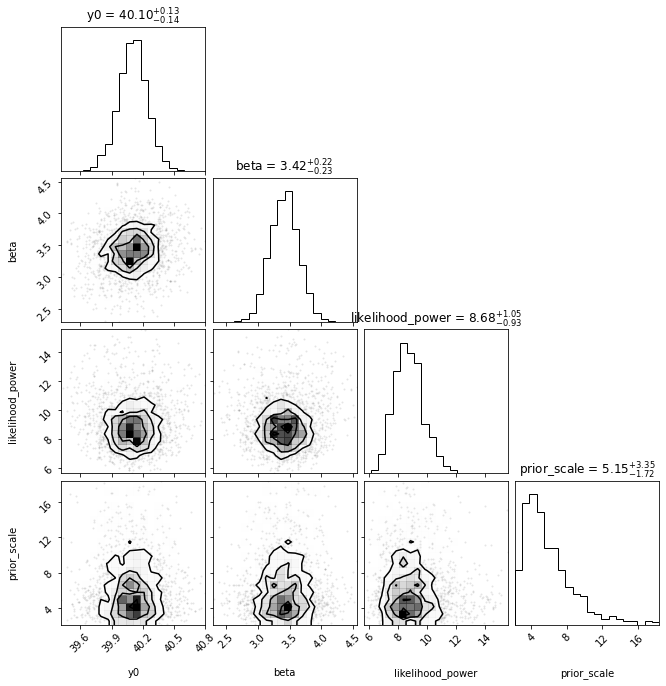

In [96]:
sampler.plot_corner()

What did our fit produce?

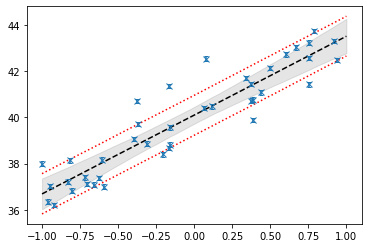

In [97]:
from ultranest.plot import PredictionBand

xgrid = np.linspace(-1, 1, 400)
band = PredictionBand(xgrid)
bandup = PredictionBand(xgrid)
bandlo = PredictionBand(xgrid)

for y0, beta, likelihood_power, _ in results['samples']:
    y_predict = y0 + xgrid * beta
    band.add(y_predict)
    bandup.add(y_predict + likelihood_power * yerr)
    bandlo.add(y_predict - likelihood_power * yerr)

band.line(color='k', ls='--')
band.shade(q=0.495, color='k', alpha=0.1)
bandup.line(color='r', ls=':')
bandlo.line(color='r', ls=':')
plt.errorbar(x=x, y=y, yerr=yerr, ls=' ', marker='x', capsize=2);



This actually looks very reasonable: Additional scatter (dotted red) was added, and the extremely high offset value (40 instead of $0\pm5$) was found!

We can also look how sensitive the posterior is to likelihood power scalings. It is very easy to reweight the weighted posterior samples:

In [98]:
weights = results['weighted_samples']['weights']
mask = weights > weights.max() / len(weights) * 1e-10
weights = weights[mask]
upoints = results['weighted_samples']['upoints'][mask,:]
points = results['weighted_samples']['points'][mask,:]
logl = results['weighted_samples']['logl'][mask]

indices = np.random.choice(len(weights), p=weights, size=len(results['samples']))


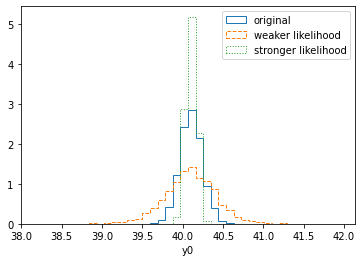

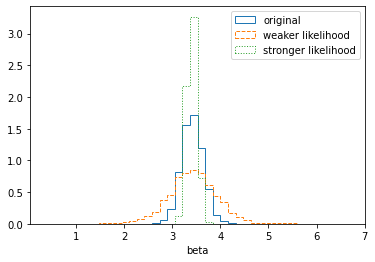

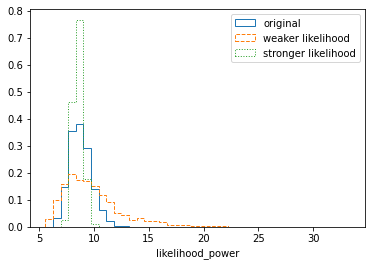

In [99]:
for i, paramname in enumerate(paramnames[:-1]):
    plt.figure()
    weights_stronglikelihood = weights * np.exp(4 * (logl - logl.max()))
    weights_weaklikelihood = weights * np.exp(-(1 - 1/4) * (logl - logl.max()))
    plt.hist(points[:,i], weights=weights, bins=40, histtype='step', label="original", density=True)
    plt.hist(points[:,i], weights=weights_weaklikelihood, bins=40, histtype='step', label="weaker likelihood", density=True, ls='--')
    plt.hist(points[:,i], weights=weights_stronglikelihood, bins=40, histtype='step', label="stronger likelihood", density=True, ls=':')
    plt.xlabel(paramname)
    plt.legend(loc='best')


Another way to look at the impact of the likelihood is to measure the information gain for each parameter:

In [101]:
results['posterior']['information_gain_bits']

[0.9842519707866588, 3.0278895789365428, 4.146479197649592, 3.9305735714280283]

In [106]:
'global information gain: %.2f +- %.2f bits' % (results['H'] / np.log(2), results['Herr'] / np.log(2))

'global information gain: 31.28 +- 0.25 bits'

If the information gain is high (e.g., >3 bits), as here for the slope parameter, we learned something from the data (and thus the likelihood).